In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [3]:
dtype=torch.FloatTensor

sentences=['i like dog','i love coffee','i hate milk']

word_list=" ".join(sentences).split()
print(word_list)
word_list=list(set(word_list))
print(word_list)
word_dict={w:i for i,w in enumerate(word_list)}
print(word_dict)
number_dict={i:w for i,w in enumerate(word_list)}
print(number_dict)
n_class=len(word_dict)
print(n_class)
#TextRNN Parameter
batch_size=len(sentences)
n_step=2
n_hidden=5

['i', 'like', 'dog', 'i', 'love', 'coffee', 'i', 'hate', 'milk']
['dog', 'hate', 'love', 'coffee', 'like', 'i', 'milk']
{'dog': 0, 'hate': 1, 'love': 2, 'coffee': 3, 'like': 4, 'i': 5, 'milk': 6}
{0: 'dog', 1: 'hate', 2: 'love', 3: 'coffee', 4: 'like', 5: 'i', 6: 'milk'}
7


In [6]:
def make_batch(sentences):
    input_batch=[]
    target_batch=[]
    
    for sen in sentences:
        word=sen.split()
        input=[word_dict[n] for n in word[:-1]]
        target=word_dict[word[-1]]
        
        input_batch.append(np.eye(n_class)[input])
        target_batch.append(target)
    return input_batch,target_batch

In [7]:
# to Torch.Tensor
input_batch,target_batch=make_batch(sentences)
input_batch=Variable(torch.Tensor(input_batch))
target_batch=Variable(torch.LongTensor(target_batch))
input_batch,target_batch

(tensor([[[0., 0., 0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 1., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 1., 0.],
          [0., 0., 1., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 0., 0., 0., 0.]]]), tensor([0, 3, 6]))

In [12]:
class TextRNN(nn.Module):
    def __init__(self):
        super(TextRNN,self).__init__()
        
        self.rnn=nn.RNN(input_size=n_class,hidden_size=n_hidden)
        self.W=nn.Parameter(torch.randn([n_hidden,n_class]).type(dtype))
        self.b=nn.Parameter(torch.randn([n_class]).type(dtype))
    def forward(self,hidden,X):
        X=X.transpose(0,1)
        outputs,hidden=self.rnn(X,hidden)
        outputs=outputs[-1]
        model=torch.mm(outputs,self.W)+self.b
        return model
model=TextRNN()
        

In [14]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [18]:
#Training
for epoch in range(5000):
    optimizer.zero_grad()
    
    hidden=Variable(torch.zeros(1,batch_size,n_hidden))
    output=model(hidden,input_batch)
    
    loss=criterion(output,target_batch)
    if (epoch+1)%1000==0:
        print('Epoch :','%04d'%(epoch+1),'cost=','{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()
input=[sen.split()[:2] for sen in sentences]


Epoch : 1000 cost= 0.013967
Epoch : 2000 cost= 0.005517
Epoch : 3000 cost= 0.002659
Epoch : 4000 cost= 0.001408
Epoch : 5000 cost= 0.000784


In [19]:
#Predict
hidden=Variable(torch.zeros(1,batch_size,n_hidden))
print(model(hidden,input_batch).data)
predict=model(hidden,input_batch).data
print(predict)
predict=predict.max(1,keepdim=True)[1]
print(predict)

tensor([[ 7.4812, -2.4364, -3.0468,  0.0732, -2.6784, -3.6486, -1.2453],
        [ 1.7341, -1.4399, -3.4219,  9.5995, -1.3894, -2.9258,  1.7093],
        [-1.4724, -1.5515, -2.7257, -1.4952, -2.2052, -3.3599,  7.1961]])
tensor([[ 7.4812, -2.4364, -3.0468,  0.0732, -2.6784, -3.6486, -1.2453],
        [ 1.7341, -1.4399, -3.4219,  9.5995, -1.3894, -2.9258,  1.7093],
        [-1.4724, -1.5515, -2.7257, -1.4952, -2.2052, -3.3599,  7.1961]])
tensor([[0],
        [3],
        [6]])


In [20]:
print(predict.squeeze())

tensor([0, 3, 6])


In [21]:
print([sen.split()[:2] for sen in sentences], '->', [number_dict[n.item()] for n in predict.squeeze()])

[['i', 'like'], ['i', 'love'], ['i', 'hate']] -> ['dog', 'coffee', 'milk']


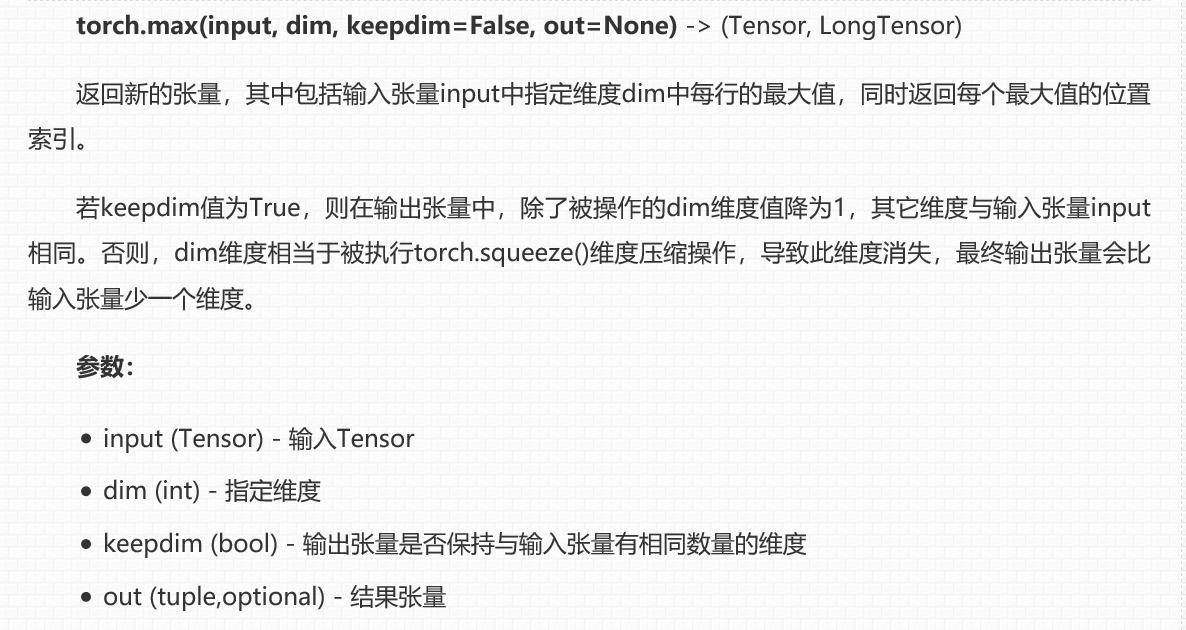

squeeze的用法主要就是对数据的维度进行压缩或者解压。

先看torch.squeeze() 这个函数主要对数据的维度进行压缩，去掉维数为1的的维度，比如是一行或者一列这种，一个一行三列（1,3）的数去掉第一个维数为一的维度之后就变成（3）行。squeeze(a)就是将a中所有为1的维度删掉。不为1的维度没有影响。a.squeeze(N) 就是去掉a中指定的维数为一的维度。还有一种形式就是b=torch.squeeze(a，N) a中去掉指定的定的维数为一的维度。

再看torch.unsqueeze()这个函数主要是对数据维度进行扩充。给指定位置加上维数为一的维度，比如原本有个三行的数据（3），在0的位置加了一维就变成一行三列（1,3）。a.squeeze(N) 就是在a中指定位置N加上一个维数为1的维度。还有一种形式就是b=torch.squeeze(a，N) a就是在a中指定位置N加上一个维数为1的维度

In [22]:
import torch
batch_index = torch.randn(2, 3, 4)
batch_es = batch_index.transpose(0, 1)
batch_ee = batch_index.transpose(1, 0)
print(batch_index)
print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
print(batch_es)
print("*********************************")
print(batch_ee)


tensor([[[-0.7222, -0.4999, -1.1348,  1.2021],
         [ 1.5583,  1.6673, -0.3929,  0.2502],
         [-1.0296, -1.3116,  0.0091,  0.4482]],

        [[-0.9963, -0.0717, -1.0457, -0.1079],
         [-0.8016,  1.9457,  0.6270,  0.5508],
         [ 0.0099, -0.9123, -1.3334, -1.6428]]])
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
tensor([[[-0.7222, -0.4999, -1.1348,  1.2021],
         [-0.9963, -0.0717, -1.0457, -0.1079]],

        [[ 1.5583,  1.6673, -0.3929,  0.2502],
         [-0.8016,  1.9457,  0.6270,  0.5508]],

        [[-1.0296, -1.3116,  0.0091,  0.4482],
         [ 0.0099, -0.9123, -1.3334, -1.6428]]])
*********************************
tensor([[[-0.7222, -0.4999, -1.1348,  1.2021],
         [-0.9963, -0.0717, -1.0457, -0.1079]],

        [[ 1.5583,  1.6673, -0.3929,  0.2502],
         [-0.8016,  1.9457,  0.6270,  0.5508]],

        [[-1.0296, -1.3116,  0.0091,  0.4482],
         [ 0.0099, -0.9123, -1.3334, -1.6428]]])


batch_es和batch_ee输出的结果是一样的。原始的transpose参数(默认的参数)为(0,1,2)，这个转置相当于将第一个坐标与第二坐标进行了互换。